<a href="https://colab.research.google.com/github/duartejr/data_science_blue/blob/master/modulo03/projeto_03/modulo_03_projeto_03_analise_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 3 - Análise de sentimento sobre o mercado financeiro


## Financial Sentiment Analysis
Este conjunto de dados reúne diversos textos sobre o mercado financeiro e categoriza cada texto em positivo, negativo e neutro.

## Sobre este projeto
Os principais pontos que serão avaliados:
* Extração de dados
* Manipulação de dados e criação de gráficos simples com o Pandas
* Criar um modelo de predição
* Apresentação dos resultados

## Preparação do ambiente
* Para este projeto, acessem o link do dataset e logo abaixo cliquem em "Download". Caso você não tenha uma conta no Kaggle, crie uma e retorne para esse ponto para realizar o download. Descompacte o arquivo.
* Este conjunto de dados está em inglês, use o Spacy e os demais dados auxiliares em inglês.
* Caso demore demais para executar ou que ocorra estouro de memória, use somente 40% dos dados.

## Exercícios

### 1.
Construa as funções e a pipeline, separe os dados em treino e teste, execute a pipeline para classificar em positivo, negativo e neutro. Quais foram os valores de acurácia, precisão e sensitividade deste modelo? (3.0 pontos)

Como sempre a primeira parte do processo consiste em análisar a consistência dos dados. Primeiramente serão importadas todas as bibliotecas e pacotes necessários e a leitura dos dados.

In [277]:
import pandas as pd
dados = pd.read_csv('data.csv')  # Leitura dos dados

O próximo passo consiste em verificar se não há valores repetidos no dataset.

Verificação do tamanho do dataset

In [278]:
dados.shape

(5842, 2)

Com o comando `drop_duplicates` podemos verificar se há valores repetidos no dataset. Caso a quantidade de resgistros após a aplicação do método seja diferente da original significa que há valores repetidos no dataset. Como critério de seleção será utilizada apenas a coluna `Sentece` pois desejo verificar se há frases repetidas no dataset. Isto é feito passando o nome da coluna como argumento do parâmetro `subset`. O parâmetro `keep = False` realiza a remoção de todos os registros repetidos, pois, caso exista frases repetidas e com classificações de sentimentos diferentes não terei, neste momento, como verificar qual a classificação mais adequada para cada frase.

In [279]:
dados.drop_duplicates(subset='Sentence', keep=False).shape

(4802, 2)

Como visto o número de linhas após aplicar o `drop_duplicates` é menor que no conjunto original, ou seja, existem frases repetidas no dataset. No próximo passo torno esta remoção permanente.

In [280]:
dados = dados.drop_duplicates(subset='Sentence', keep=False)
dados.shape

(4802, 2)

Em sequência irei verificar se há desbalanceamento entre as classes.

In [281]:
dados.Sentiment.value_counts()

neutral     2604
positive    1852
negative     346
Name: Sentiment, dtype: int64

O passo anterior mostra que a classe de argumentos neutros (`neutral`) têm maior frequência que as demais e a de argumentos negativos (`negative`) é a de menor frequência. Como o desbalanceamento pode acarretar na tendência do modelo gerar mais respostas para uma única classe será feito o balanceamento das mesmas. O balanceamento será feito selecionando 346 amostras aleatórias das classes `neutral` e `positive`, assim todas as classes terão a mesma frequência.

In [282]:
neutros = dados.query('Sentiment == "neutral"').sample(346)     # Seleção de 346 amostras aleatórias da classe neutral
positive = dados.query('Sentiment == "positive"').sample(346)   # Seleção de 346 amostras aleatórias da classe positive
negative = dados.query('Sentiment == "negative"')               # Seleção de todas as amostras da classe negative

dados2 = pd.concat([neutros, positive, negative])               # Concatenação de todas as amostras em um único dataframe
dados2 = dados2.sample(frac=1).reset_index()                    # Embaralhamento das amostras
dados2.Sentiment.value_counts()


neutral     346
negative    346
positive    346
Name: Sentiment, dtype: int64

Após o tratamento dos dados podemos então iniciar a construção do modelo de classificação de sentimentos. Nas célula a seguir são definidas todas as funções e métodos para a construção do modelo.

In [283]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

nlp = spacy.load('en')

# Criamos uma classe para gerenciar X e y
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Esta funcao remove espacos em branco no inicio e
# no fim do texto e converte todo o texto em letras
# minusculas
def clean_text(texto):     
    return texto.strip().lower()

# Esta funcao remove todas as stopwords e pontuacoes
def tokenizer(texto):
    doc = nlp(texto)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens

# Criamos um objeto CountVectorizer para vetorizar cada texto
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1)) 

# Criamos um modelo Gradient Boosting o valores dos hiper-parâmetros foram definidos após alguns testes
classifier = GradientBoostingClassifier(min_samples_leaf=8, max_depth=7, random_state=101)

# Construindo uma pipeline
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

Feita a definição do modelo os próximos passos são: separar as variáveis dependentes e independentes, separar os conjuntos de treino e teste, treinar e avaliar o modelo.

In [284]:
from sklearn.model_selection import train_test_split

# Separando em X e y
X = dados2.Sentence
y = dados2.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print('Acurácia = ', round(accuracy_score(y_test, y_pred), 3))
print('Precisão = ', round(precision_score(y_test, y_pred, average='macro'), 3))
print('Recall = ', round(recall_score(y_test, y_pred, average='macro'), 3))

Acurácia =  0.678
Precisão =  0.705
Recall =  0.685


### 2.
Use o seu modelo para classificar os seguintes textos extraídos do site Financial Times. Faça uma tabela com o valor esperado e o valor obtido, e responda: houve divergência entre o esperado e o obtido? O que poderia ser feito para corrigir? (1.0 ponto)

a. Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety. resultado esperado: [negativo]</br>
b. China opens up bond market in bid to woo foreign investors. resultado esperado: [neutro]</br>
c. HM Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this. resultado esperado: [negativo]</br>
d. Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism. resultado esperado: [negativo]</br>
e. Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate. resultado esperado: [neutro]</br>

In [285]:
amostras = ["Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety.",
            "China opens up bond market in bid to woo foreign investors.",
            "M Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this.",
            "Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism.",
            "Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate."]

pred = pipe.predict(amostras)
pred

array(['positive', 'neutral', 'neutral', 'neutral', 'neutral'],
      dtype=object)

Aparentemente o modelo tende a classificar mais frases como neutras. Mas, como a amostra é muito pequena esta afirmativa é inconclusiva.

### 3.
Faça uma análise exploratória, onde identifique as três empresas mais citadas e quantifique os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas. (3.0 pontos)

a. Extraia de todos os textos as entidades, há quantas entidades? (0.6 pontos) 

Foi verificado em passos antetiores, não mostrados aqui, que o Spacy classifica erroneamente as labels ['oyj', 'eur'] como empresas. Para evitar esta contagemm erronea optei por ignorar a ocorrência delas.

In [286]:
entidades = []

for i in dados.index:
    doc = nlp(dados.loc[i, 'Sentence'].lower())
    for ent in doc.ents:
        if ent.text not in ['oyj', 'eur']:
            entidades.append([ent.text, ent.label_, dados.loc[i, 'Sentiment']])

entidades = pd.DataFrame(entidades, columns=['entidade', 'label', 'sentimento'])

In [287]:
print('Total de entidades encontradas = ', len(entidades.groupby('entidade')))

Total de entidades encontradas =  5726


b. Quantas entidades são empresas? (0.6 pontos) 

In [288]:
n_empresas = len(entidades.query('label == "ORG"')['entidade'].drop_duplicates())
print('Total de empresas reconhecidas: ', n_empresas)

Total de empresas reconhecidas:  1262


c. Quais são as três empresas mais citadas? (0.6 pontos)

In [289]:
entidades.query('label == "ORG"')['entidade'].value_counts().sort_values(ascending=False)[:3]

nokia     47
tesco     29
ruukki    25
Name: entidade, dtype: int64

d. Faça uma tabela onde demonstre as três empresas mais citadas e o total de textos positivos, negativos e neutros de cada uma. (1.2 pontos)

In [290]:
top3_empresas = entidades.query('label == "ORG" and entidade in ["nokia", "tesco", "ruukki"]')
pd.crosstab(top3_empresas.entidade, top3_empresas.sentimento)

sentimento,negative,neutral,positive
entidade,,,
nokia,0,31,16
ruukki,0,11,14
tesco,11,3,15


### 4.
Faça gráficos a partir da tabela obtida acima. Descreva cada gráfico de forma que estivesse apresentando à diretoria dessas três empresas. (3.0 pontos)

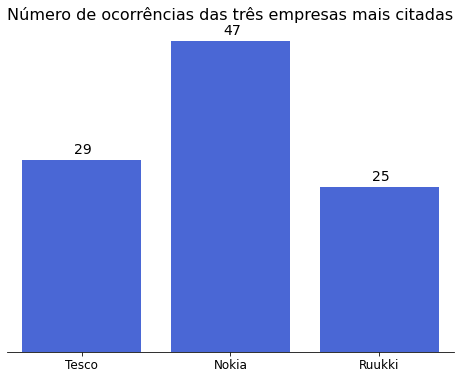

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.countplot(data=top3_empresas, x='entidade', ax=ax, color='#3359ec')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(['Tesco', 'Nokia', 'Ruukki'], fontsize=12)
ax.get_yaxis().set_visible(False)
ax.set_title('Número de ocorrências das três empresas mais citadas', fontsize=16)

for p in ax.patches:
    txt = str(p.get_height())
    txt_x = p.get_x() + .35
    txt_y = p.get_height() + 1
    ax.text(txt_x, txt_y, txt, fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

Dentro do dataset fornecido a empresa mais citada é a Nokia, isto pode ser um indicativo da popularidade da empresa. Tesco e Ruukki são menos citadas. Isto acaba sendo um reflexo do ramo de atuação de cada empresa. Como a Nokia é uma empresa maior com atuação global e com várias campanhas de marketing, acaba tendo mais clientes e consequenteme mais investidores e aparições na base de dados. Tesco é uma multinacional varejista britânica, de pequenas lojas a hipermercados, sediada no Reino Unido. E a Rautaruukki (Ruukki) é uma empresa finlândesa que fabrica produtos de derivados do aço, a empresa desenvolve e fabrica tubos, tubos de linha e produtos de construção em aço. São portanto empresas menores que a Nokia e por causa disto atraem a atenção de menos investidores.

Executando-se a célula a seguir têm-se a distribuição dos sentimentos atribuidos aos comentários de cada uma das empresas que estão no TOP 3.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


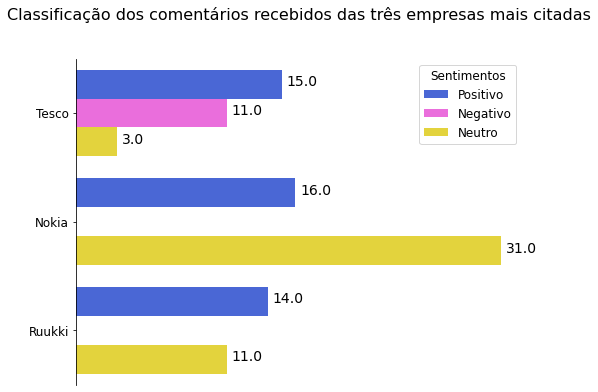

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.countplot(
    data=top3_empresas, 
    y='entidade', 
    hue='sentimento', 
    ax=ax, 
    palette=['#3359ec', '#ff59ec', '#ffe921']
)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels(['Tesco', 'Nokia', 'Ruukki'], fontsize=12)
ax.get_xaxis().set_visible(False)
ax.set_title('Classificação dos comentários recebidos das três empresas mais citadas', fontsize=16, y=1.1)

for p in ax.patches:
    txt = str(p.get_width())
    txt_x = p.get_width() + .35
    txt_y = p.get_y() + .15
    ax.text(txt_x, txt_y, txt, fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.legend(['Positivo', 'Negativo', 'Neutro'], title='Sentimentos', fontsize=12, title_fontsize=12)
plt.show()

A partir do gráfico acima podemos notar que, embora a Nokia seja a empresa que, em termos absolutos, têm a maior quantidade de comentários, seus investidores parecem não estar animados com o desempenho da mesma, já que a maioras dos comentários sobre a Nokia são classificados como neutros.

Os investidores da Ruukki aparentam ser os mais satisfeitos com o desempenho da empresa pois, além da mesma não estar relacionada a comentários negativos a maioria de seus comentários recebidos são positivos.

Por fim, a Tesco é a empresa de menor satisfação dos investidores. A empresa precisa tomar ações para recupear a credibilidade com seus investidores.